In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
import cv2
import os
import glob
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.12 torch-2.3.0+cu121 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/107.7 GB disk)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def classify_image(
    width_ratio,
    height_ratio,
    relative_x_position,
    distance_from_top,
    distance_from_bottom
):
    if height_ratio < 0.3:
        return 1  # Small_Figure
    elif height_ratio > 0.7:
        return 2  # Large_Figure
    elif distance_from_bottom > 0.3:
        return 3  # Excessive_Floor
    elif distance_from_bottom < 0.01:
        return 4  # Limited_Floor
    elif relative_x_position < 0.3 or relative_x_position > 0.7:
        return 5  # Off_Center_Figure
    else:
        return 0  # Full_Body_Visible

In [ ]:
import cv2
import torch
import os

# YOLO 모델 로드 및 실행
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # 모델 버전에 따라 변경 가능

class_names = ["Full_Body_Visible", "Small_Figure", "Large_Figure", "Excessive_Floor", "Limited_Floor", "Off_Center_Figure" ]
target_class_index = 0  # 관심 있는 클래스 인덱스

# 분류 결과를 저장할 배열
classification_results = []
folder_path = "/content/drive/MyDrive/Grad_project/test1"

# 폴더 내 모든 이미지 파일을 순회
for file_name in os.listdir(folder_path):
    # 파일 확장자가 이미지인지 확인
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(folder_path, file_name)
        # 이미지 로드
        img = cv2.imread(file_path)
        if img is None:
            continue  # 이미지 파일이 아니거나 읽을 수 없는 파일은 건너뜀
        height, width, _ = img.shape

        # YOLO 모델 실행
        results = model(img)

        # 가장 높은 신뢰도를 가진 결과만 찾기
        max_conf = 0
        best_det = None
        for *xyxy, conf, cls in results.xyxy[0]:
            if cls == target_class_index and conf > max_conf:  # 클래스 0이면서 가장 높은 신뢰도
                max_conf = conf
                best_det = (*xyxy, conf, cls)

        if best_det:
            x1, y1, x2, y2, conf, cls = best_det
            # 기타 계산 및 분류
            width_ratio = (x2 - x1) / width
            height_ratio = (y2 - y1) / height
            relative_x_position = (x1 + x2) / (2 * width)
            distance_from_top = y1 / height
            distance_from_bottom = 1 - (y2 / height)

            # 분류 결과 얻기
            classification = classify_image(width_ratio, height_ratio, relative_x_position, distance_from_top, distance_from_bottom)
            classification_results.append((file_name, classification))

# 배열에 저장된 결과 출력
for result in classification_results:
    print(f"Image: {result[0]}, Classification: {result[1]} {class_names[result[1]]}")

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-314-g60dde7f1 Python-3.10.12 torch-2.3.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 133MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


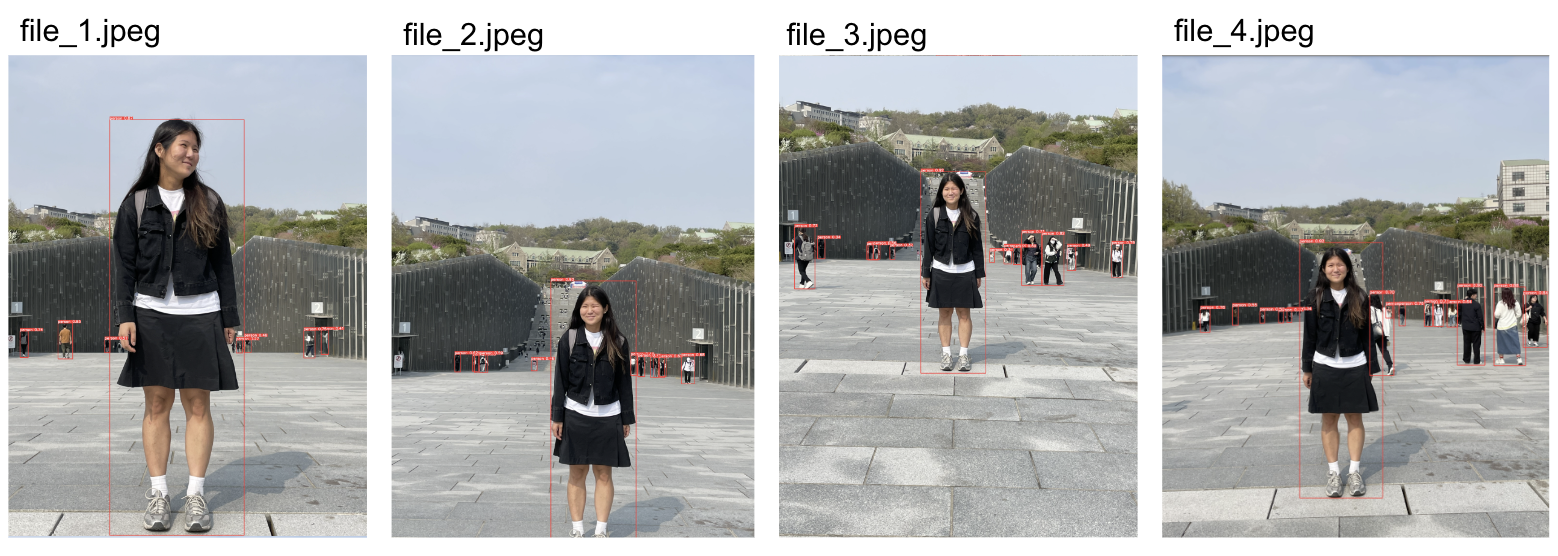

데이터셋 분류하기

In [ ]:
# 분류 결과를 저장할 배열
classification_results = []
folder_path = "/content/drive/MyDrive/Grad_project/dataset"

# 폴더 내 모든 이미지 파일을 순회
for file_name in os.listdir(folder_path):
    # 파일 확장자가 이미지인지 확인
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(folder_path, file_name)
        # 이미지 로드
        img = cv2.imread(file_path)
        if img is None:
            continue  # 이미지 파일이 아니거나 읽을 수 없는 파일은 건너뜀
        height, width, _ = img.shape

        # YOLO 모델 실행
        results = model(img)

        # 가장 높은 신뢰도를 가진 결과만 찾기
        max_conf = 0
        best_det = None
        for *xyxy, conf, cls in results.xyxy[0]:
            if conf > max_conf:
                max_conf = conf
                best_det = (*xyxy, conf, cls)

        if best_det:
            x1, y1, x2, y2, conf, cls = best_det
            # 기타 계산 및 분류
            width_ratio = (x2 - x1) / width
            height_ratio = (y2 - y1) / height
            relative_x_position = (x1 + x2) / (2 * width)
            distance_from_top = y1 / height
            distance_from_bottom = 1 - (y2 / height)

            # 분류 결과 얻기
            classification = classify_image(width_ratio, height_ratio, relative_x_position, distance_from_top, distance_from_bottom)
            classification_results.append((file_name, classification))

# 라벨링 결과 출력
print(classification_results)

[ Dataset ] train set & test set 나누기

In [ ]:
import torch
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# 사용자 정의 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, img_labels, transform=None):
        """
        img_labels: 이미지 경로와 레이블이 튜플로 된 리스트
        transform: torchvision에서 제공하는 변환 방법
        """
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img_path = folder_path + '/' + img_path

        # OpenCV를 사용하여 이미지를 BGR 형식으로 로드
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # BGR에서 RGB로 변환
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(f"The image at path {img_path} could not be loaded.")

        # PIL Image로 변환 (선택적: 만약 변환을 PIL 기반으로 하려면)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 변환 규칙 정의
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 파일 경로와 레이블 목록
files_and_labels = classification_results
# files_and_labels = balanced_results

# 데이터셋 인스턴스 생성
dataset = CustomImageDataset(files_and_labels, transform=transform)

# 난수 생성기 설정
generator = torch.Generator()
generator.manual_seed(42)

# 데이터셋을 훈련과 테스트로 분할
train_size = int(0.7 * len(dataset))  # 전체 데이터셋의 80%를 훈련 데이터로 사용
test_size = len(dataset) - train_size  # 나머지 20%를 테스트 데이터로 사용
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 훈련용 데이터 로더와 테스트용 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

모델 정의하고, 학습시키기

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 입력 채널 3 (RGB), 출력 채널 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 맥스풀링
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # 첫 번째 fully connected layer
        self.fc2 = nn.Linear(512, 6)  # 출력 크기는 클래스 개수 (6개)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)  # Flatten the layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
import torch.optim as optim

# 모델 인스턴스 생성
model = SimpleCNN()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 분류 문제의 경우 CrossEntropyLoss 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 사용
# 학습 반복 횟수
epochs = 15

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print('학습완료')


Epoch 1, Loss: 11.216105898221334
Epoch 2, Loss: 3.2272375424702964
Epoch 3, Loss: 1.5606668790181477
Epoch 4, Loss: 1.1541012128194172
Epoch 5, Loss: 1.0151522954305012
Epoch 6, Loss: 0.6564057668050131
Epoch 7, Loss: 0.6306901077429453
Epoch 8, Loss: 0.37907617290814716
Epoch 9, Loss: 0.31146788597106934
Epoch 10, Loss: 0.25055411954720813
Epoch 11, Loss: 0.07811874647935231
Epoch 12, Loss: 0.07184000002841155
Epoch 13, Loss: 0.025391029193997383
Epoch 14, Loss: 0.02126903397341569
Epoch 15, Loss: 0.0056726159527897835
학습완료


In [ ]:
import torch
from sklearn.metrics import f1_score, confusion_matrix

# 테스트 루프
def test_model(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # F1 스코어 계산
    f1_scores = f1_score(all_labels, all_predicted, average=None)  # 각 클래스별 F1 스코어

    # 혼동 행렬 생성 및 각 클래스별 정확도 계산
    cm = confusion_matrix(all_labels, all_predicted)
    class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)  # 각 클래스별 정확도

    print("Performance per class:")
    for i in range(len(f1_scores)):
        accuracy = class_accuracy[i] if i < len(class_accuracy) else 0  # 혹시 누락된 클래스가 있다면 0으로 처리
        print(f'Class {i}: Accuracy: {accuracy:.2f}%, F1 Score: {f1_scores[i]:.4f}')

test_model(model, test_loader)

Performance per class:
Class 0: Accuracy: 44.44%, F1 Score: 0.4706
Class 1: Accuracy: 66.67%, F1 Score: 0.5000
Class 2: Accuracy: 14.29%, F1 Score: 0.1818
Class 3: Accuracy: 0.00%, F1 Score: 0.0000
Class 4: Accuracy: 50.00%, F1 Score: 0.4000


모델 저장하기

In [ ]:
def print_label_proportions(loader):
    label_counts = {}
    total_count = 0

    # 레이블의 빈도를 계산합니다.
    for data, labels in loader:
        for label in labels:
            label = label.item()
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
            total_count += 1

    # 레이블 비율을 계산하고 출력합니다.
    # 레이블을 정렬된 순서로 출력합니다.
    for label in sorted(label_counts):
        proportion = label_counts[label] / total_count
        print(f"Label {label}: {proportion:.2f}")

print("Train Loader")
print_label_proportions(train_loader)

Train Loader
Label 0: 0.55
Label 1: 0.14
Label 2: 0.11
Label 3: 0.01
Label 4: 0.09
Label 5: 0.09


In [ ]:
import torch
# 테스트 루프
def test_model():
    model.eval()  # 모델을 평가 모드로 설정
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

test_model()

print('Training and testing complete')




Accuracy: 50.0%
Training and testing complete


In [ ]:
import torch
from sklearn.metrics import roc_auc_score

# Assuming 'model' and 'test_loader' are defined elsewhere

def test_model(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    total = 0
    correct = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assumes binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.numpy())

    accuracy = 100 * correct / total
    auc_roc = roc_auc_score(all_labels, all_probs)
    print(f'Accuracy: {accuracy}%')
    print(f'AUC-ROC: {auc_roc}')

# Example usage:
test_model(model, test_loader)


ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
def print_label_proportions(loader):
    label_counts = {}
    total_count = 0

    # 레이블의 빈도를 계산합니다.
    for data, labels in loader:
        for label in labels:
            label = label.item()
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
            total_count += 1

    # 레이블 비율을 계산하고 출력합니다.
    # 레이블을 정렬된 순서로 출력합니다.
    for label in sorted(label_counts):
        proportion = label_counts[label] / total_count
        print(f"Label {label}: {proportion:.2f}")

print_label_proportions(train_loader)
print_label_proportions(test_loader)

Label 0: 0.51
Label 1: 0.18
Label 2: 0.08
Label 3: 0.03
Label 4: 0.11
Label 5: 0.09
Label 0: 0.55
Label 1: 0.09
Label 2: 0.21
Label 4: 0.09
Label 5: 0.06


In [ ]:
def evaluate_model(model, data_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    total = [0] * num_classes
    correct = [0] * num_classes

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    # print("target", label, "prediction", prediction)
                    correct[label] += 1
                total[label] += 1

    # Calculate and print accuracy for each class
    for i in range(num_classes):
        if total[i] == 0:
            print(f'No samples for class {i}.')
        else:
            accuracy = 100 * correct[i] / total[i]
            print(f'Precision for class {i}: {accuracy:.2f}%')

# Assuming num_classes is the number of distinct labels in your dataset
num_classes = 6  # Modify this as per your dataset
evaluate_model(model, test_loader, num_classes)

Precision for class 0: 80.00%
Precision for class 1: 83.33%
Precision for class 2: 0.00%
No samples for class 3.
Precision for class 4: 0.00%
Precision for class 5: 0.00%
